In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, auc, roc_curve

In [58]:
# Load the dataset
data = pd.read_csv('/content/creditcard.csv')


In [59]:
# Check for missing values in 'Class' column
missing_values = data['Class'].isnull().sum()
if missing_values > 0:
    print("Warning: Missing values found in the 'Class' column. Handling missing values...")
    data.dropna(subset=['Class'], inplace=True)

In [60]:
# Convert 'Class' column to integers
data['Class'] = data['Class'].astype(int)

In [61]:
# Check class distribution
class_counts = data['Class'].value_counts()
print(class_counts)

0    73198
1      178
Name: Class, dtype: int64


In [62]:
# Preprocessing and feature scaling
scaler = StandardScaler()
data['Amount'] = scaler.fit_transform(data['Amount'].values.reshape(-1, 1))
data.drop('Time', axis=1, inplace=True)

In [63]:
# Splitting the data
X = data.drop('Class', axis=1)
y = data['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [64]:
# Handling class imbalance with oversampling and undersampling
ros = RandomOverSampler(random_state=42)
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
X_train_undersampled, y_train_undersampled = rus.fit_resample(X_train, y_train)


In [65]:
# Training classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42)
}

results = {}

for name, clf in classifiers.items():
    print(f"Training {name} model...")
    clf.fit(X_train_resampled, y_train_resampled)

    # Evaluating the model
    y_pred = clf.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(f"\n{name} Model:")
    print(conf_matrix)
    print(classification_report(y_test, y_pred))

    results[name] = {'model': clf, 'confusion_matrix': conf_matrix}

Training Random Forest model...

Random Forest Model:
[[14639     1]
 [    8    28]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14640
           1       0.97      0.78      0.86        36

    accuracy                           1.00     14676
   macro avg       0.98      0.89      0.93     14676
weighted avg       1.00      1.00      1.00     14676

Training Logistic Regression model...

Logistic Regression Model:
[[14332   308]
 [    5    31]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     14640
           1       0.09      0.86      0.17        36

    accuracy                           0.98     14676
   macro avg       0.55      0.92      0.58     14676
weighted avg       1.00      0.98      0.99     14676



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


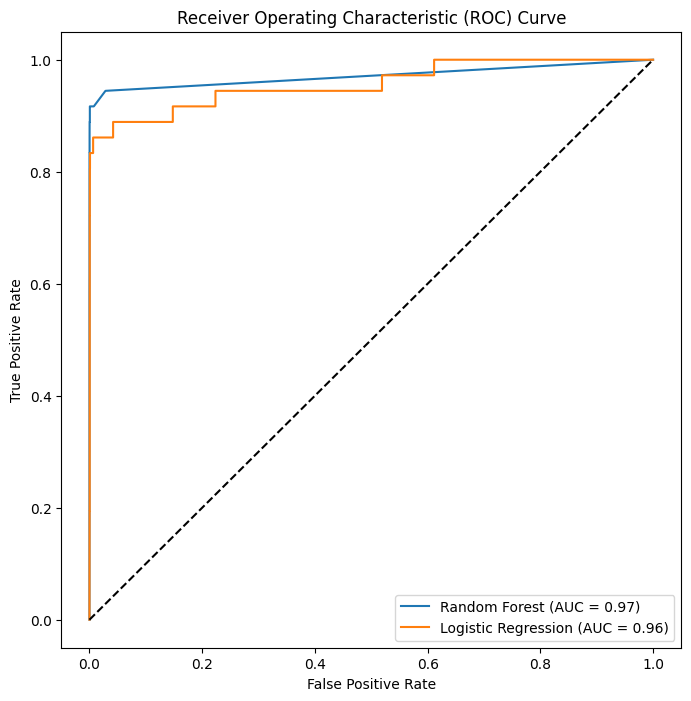

In [66]:
# Visualize ROC Curves
plt.figure(figsize=(8, 8))
for name, result in results.items():
    fpr, tpr, thresholds = roc_curve(y_test, result['model'].predict_proba(X_test)[:, 1])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


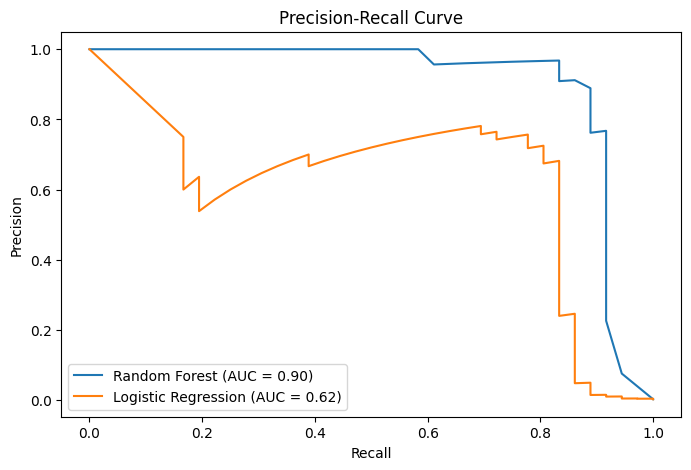

In [67]:
# Visualize Precision-Recall Curves
plt.figure(figsize=(8, 5))
for name, result in results.items():
    precision, recall, _ = precision_recall_curve(y_test, result['model'].predict_proba(X_test)[:, 1])
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f'{name} (AUC = {pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


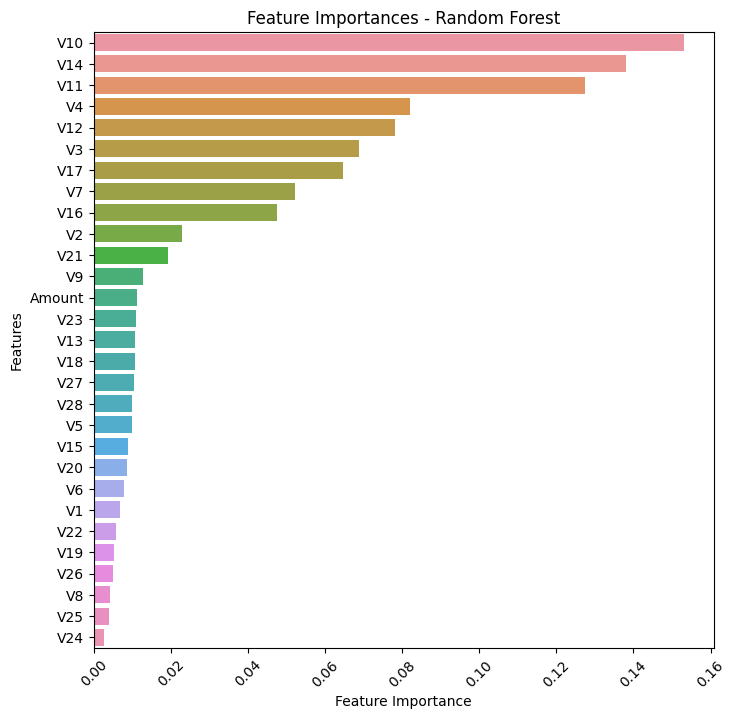

In [68]:
# Visualize Feature Importances (Random Forest model)
if 'Random Forest' in results:
    plt.figure(figsize=(8, 8))
    feature_importances = results['Random Forest']['model'].feature_importances_
    sorted_idx = np.argsort(feature_importances)[::-1]
    features = X.columns
    sns.barplot(x=feature_importances[sorted_idx], y=features[sorted_idx])
    plt.xlabel('Feature Importance')
    plt.ylabel('Features')
    plt.title('Feature Importances - Random Forest')
    plt.xticks(rotation=45)
    plt.show()